# Analysis of scRNA-seq data

## FeatureCounts quantification

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad(
    '../processed/scRNAseq_featureCounts.h5ad'
)

In [3]:
adata.obs['nCount_RNA'] = np.array(adata.X.sum(axis = 1)).flatten()
adata.obs['nFeature_RNA'] = np.array((adata.X > 0).sum(axis = 1)).flatten()
adata.obs['percent_mt'] = \
    np.array(adata[:, adata.var.index.str.startswith('mt')].X.sum(axis = 1)).flatten() / \
    np.array(adata.X.sum(axis = 1)).flatten()
adata.obs['percent_ribo'] = \
    np.array(adata[:, adata.var.index.str.match('^Rp[sl]')].X.sum(axis = 1)).flatten() / \
    np.array(adata.X.sum(axis = 1)).flatten()

In [4]:
adata.obs.groupby('sample_mouseID').count()

,sample_description,sample_genotype,sample_treatment,sample_sex,sample_litter,nCount_RNA,nFeature_RNA,percent_mt,percent_ribo
sample_mouseID,,,,,,,,,
GN21/475,67,67,67,67,67,67,67,67,67
GNF1/464,37,37,37,37,37,37,37,37,37
GNF1/469,50,50,50,50,50,50,50,50,50
GNF1/473,64,64,64,64,64,64,64,64,64
GNF1/480,65,65,65,65,65,65,65,65,65
GNF1/483,61,61,61,61,61,61,61,61,61


In [5]:
#removing mouse litter G1/55 A
adata = adata[~(adata.obs.sample_litter == 'G1/55 A'), :].copy()
adata

AnnData object with n_obs × n_vars = 222 × 54456
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length'

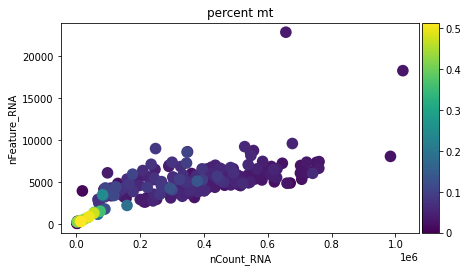

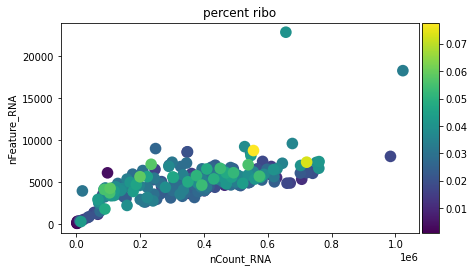

In [6]:
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_mt'
)
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_ribo'
)

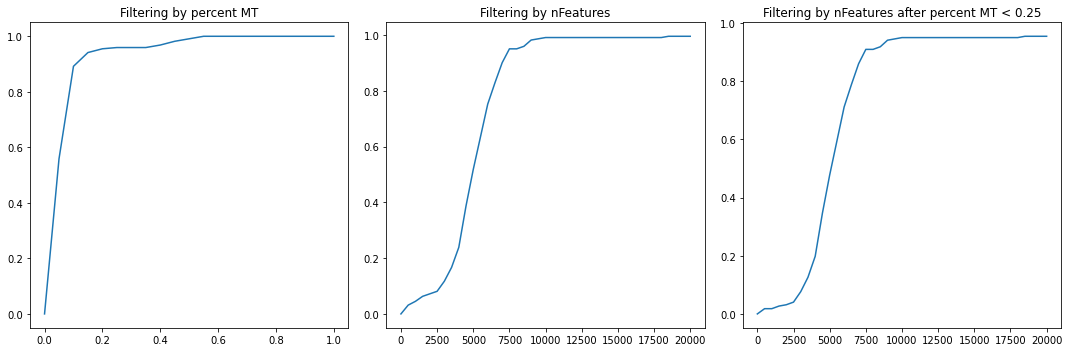

In [7]:
# Filtering cells
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
x1 = np.linspace(0, 1, 21)
data1 = [(adata.obs.percent_mt < i).sum()/len(adata.obs) for i in x1]
ax1.plot(x1, data1)
ax1.set_title('Filtering by percent MT')

x2 = np.linspace(0, 20000, 41)
data2 = [(adata.obs.nFeature_RNA < i).sum()/len(adata.obs) for i in x2]
ax2.plot(x2, data2)
ax2.set_title('Filtering by nFeatures')

data3 = [(adata[adata.obs.percent_mt < 0.25].obs.nFeature_RNA < i).sum()/len(adata.obs) for i in x2]
ax3.plot(x2, data3)
ax3.set_title('Filtering by nFeatures after percent MT < 0.25')

fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()

In [8]:
adata = adata[
    (adata.obs.nFeature_RNA > 2000) & 
    (adata.obs.nFeature_RNA < 15000) &
    (adata.obs.nCount_RNA < 900000) &
    (adata.obs.percent_mt < 0.2), :].copy()
adata

AnnData object with n_obs × n_vars = 202 × 54456
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length'

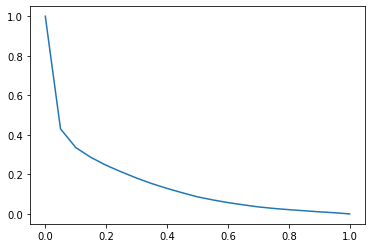

In [9]:
# Filtering genes
sc.pp.filter_genes(adata, min_counts = 5)

fig, ax = plt.subplots()
x = np.linspace(0, 1, 21)
expressed = np.array((adata.X > 0).sum(axis = 0)).flatten()/len(adata.obs)
data = [(expressed > i).sum()/len(expressed) for i in x]
ax.plot(x, data)

In [10]:
adata = adata[
    :, 
    ~adata.var.index.str.match('^Rp[sl]') & 
    ~adata.var.index.str.startswith('mt') & 
    (np.array((adata.X > 0).sum(axis = 0)).flatten() > 2)
].copy()
adata

AnnData object with n_obs × n_vars = 202 × 26555
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length', 'n_counts'

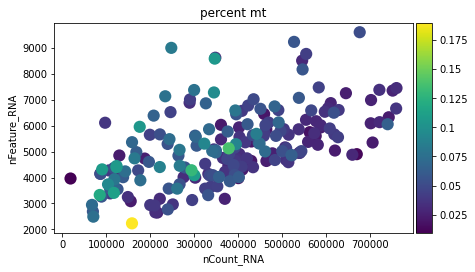

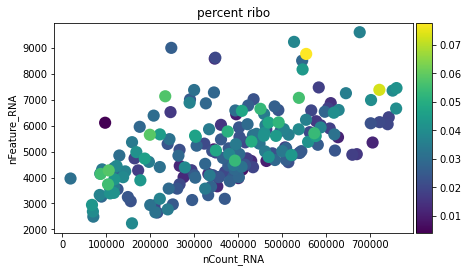

In [11]:
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_mt'
)
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_ribo'
)

In [12]:
adata.write_h5ad(
    '../processed/scRNAseq_featureCounts.filtered.h5ad'
)

In [13]:
def normalize_tpm(adata, scale = 1e4):
    X = adata.X.toarray().T / adata.var.Length.values[:, None] * 1000
    factors = X.sum(axis = 0) / scale
    return X.T / factors[:, None]

adata = sc.read_h5ad(
    '../processed/scRNAseq_featureCounts.filtered.h5ad'
)
adata.layers['counts'] = adata.X.copy()
#adata.layers['tpm'] = normalize_tpm(adata, scale = 1e6)
#adata.X = adata.layers['tpm'].copy()
adata

AnnData object with n_obs × n_vars = 202 × 26555
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length', 'n_counts'
    layers: 'counts'

In [14]:
#basically seurat preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [15]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1500,
    layer = 'counts',
    flavor = 'seurat_v3'
)

In [16]:
sc.pp.pca(
    adata, 
    n_comps = 40, 
    svd_solver = 'arpack',
    use_highly_variable = True,
)
sc.pp.neighbors(
    adata,
    n_neighbors = 5,
    knn = True
)
sc.tl.umap(adata)

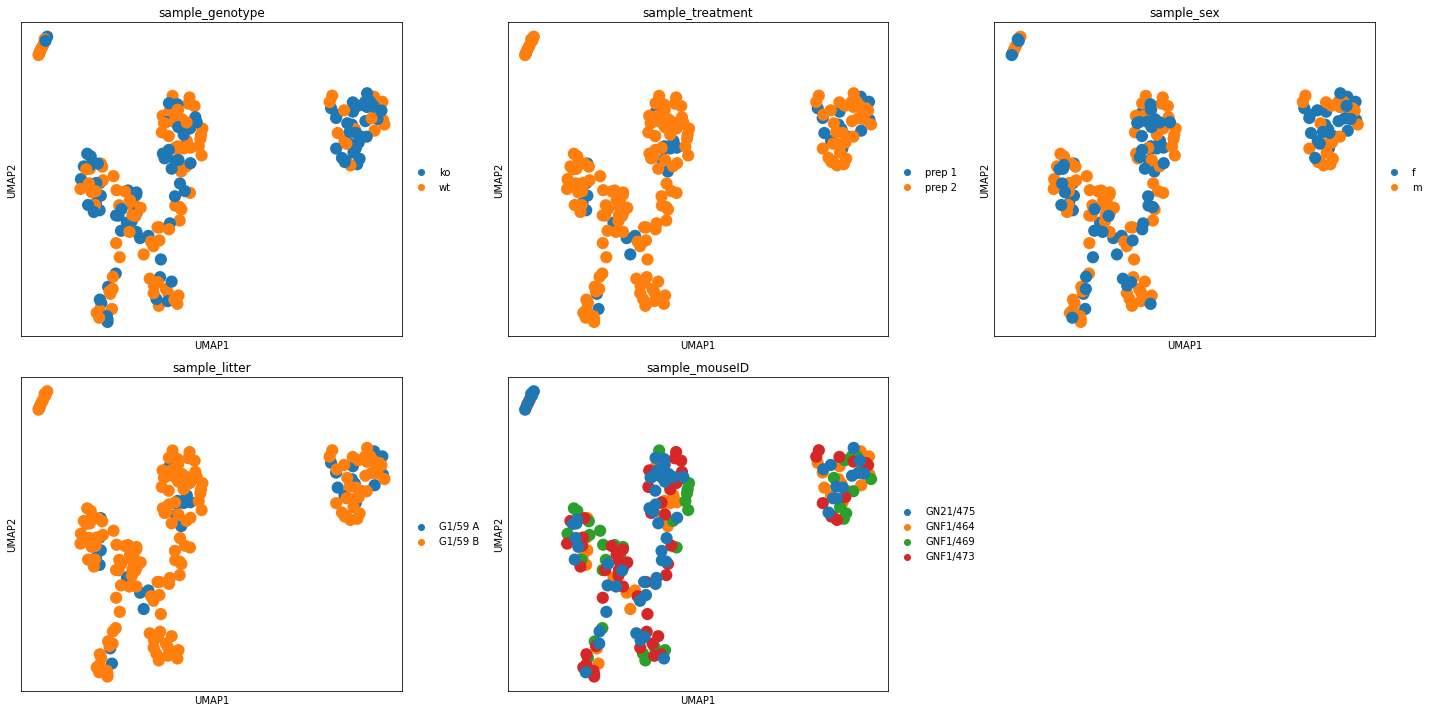

In [17]:
fig, axs = plt.subplots(2, 3)
keys = ['sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID']
for key, ax in zip(keys, axs.reshape(6)):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax
    )

axs[-1, -1].remove()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [18]:
# installing leiden and louvain algorithm package
# !pip install leidenalg louvain

In [19]:
resolutions = [0.25, 0.5, 0.75, 1]
for resolution in resolutions:
    sc.tl.leiden(
        adata, 
        resolution = resolution,
        key_added=f'leiden_r{resolution}'
    )

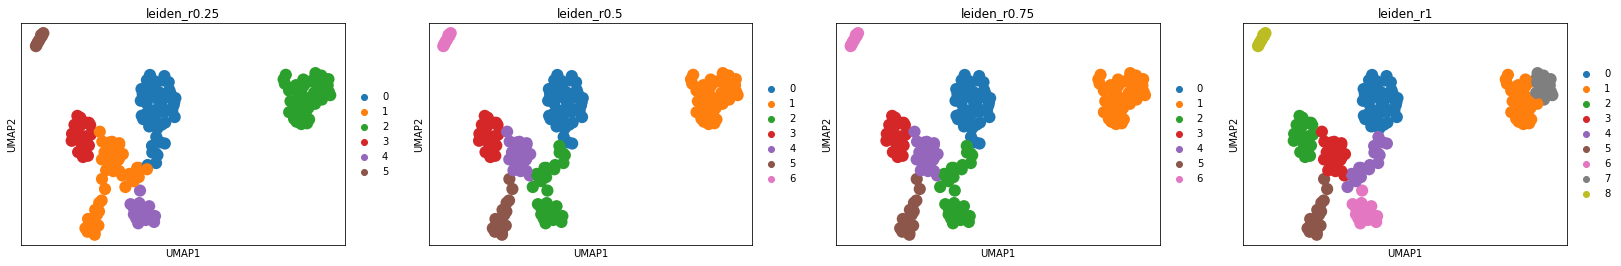

In [20]:
sc.pl.umap(
    adata,
    color = [f'leiden_r{resolution}' for resolution in resolutions]
)

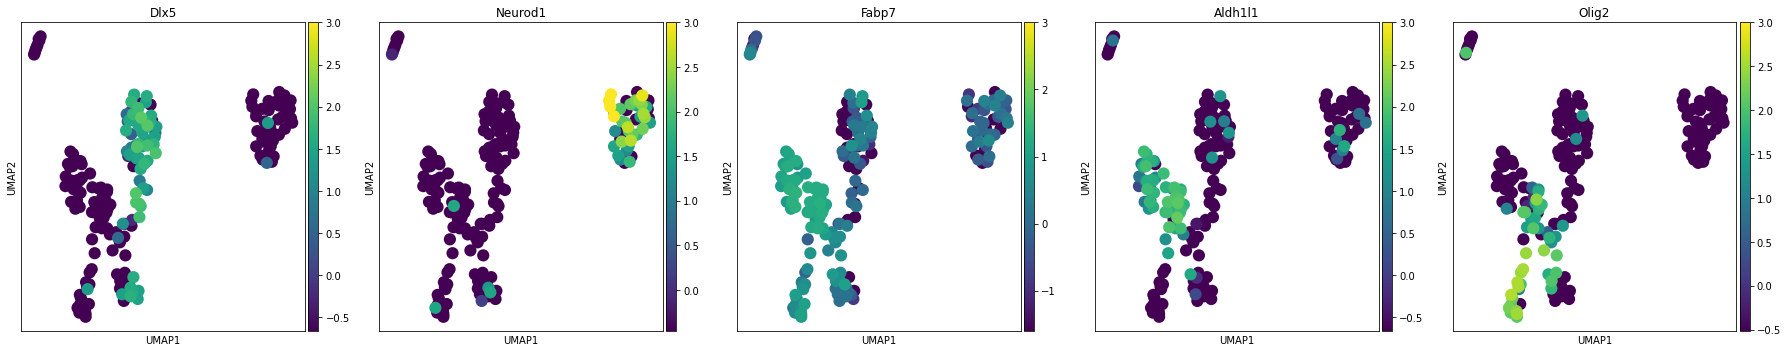

In [21]:
fig, axs = plt.subplots(1, 5)
keys = ['Dlx5', 'Neurod1', 'Fabp7', 'Aldh1l1', 'Olig2']
for key, ax in zip(keys, axs):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax,
        vmax = 3
    )

fig.set_figwidth(25)
fig.set_figheight(5)
fig.tight_layout()

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


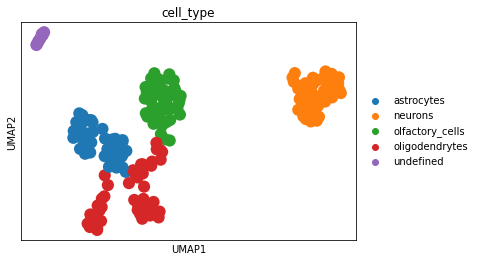

In [22]:
# Dlx5 is a marker of olfactory cells, Neurod1 is a marker of neurons, Fabp7 and Aldh1l1 are markers of astrocytes and Olig2 is a marker of oligodendrytes
cell_assignment = {
    '0': 'olfactory_cells',
    '1': 'neurons',
    '2': 'oligodendrytes',
    '3': 'astrocytes',
    '4': 'astrocytes',
    '5': 'oligodendrytes',
    '6': 'undefined'
}
adata.obs['cell_type'] = adata.obs['leiden_r0.5'].apply(
    lambda x: cell_assignment[x]
)
sc.pl.umap(
    adata,
    color = 'cell_type'
)

In [23]:
adata.write(
    '../processed/scRNAseq_featureCounts.clustered.h5ad'
)

## Salmon quantification

In [24]:
adata = sc.read_h5ad(
    '../processed/scRNAseq_salmon.h5ad'
)
adata.X = adata.layers['counts'].copy()

In [25]:
adata.obs['nCount_RNA'] = np.array(adata.X.sum(axis = 1)).flatten()
adata.obs['nFeature_RNA'] = np.array((adata.X > 0).sum(axis = 1)).flatten()
adata.obs['percent_mt'] = \
    np.array(adata[:, adata.var.index.str.startswith('mt')].X.sum(axis = 1)).flatten() / \
    np.array(adata.X.sum(axis = 1)).flatten()
adata.obs['percent_ribo'] = \
    np.array(adata[:, adata.var.index.str.match('^Rp[sl]')].X.sum(axis = 1)).flatten() / \
    np.array(adata.X.sum(axis = 1)).flatten()

In [26]:
#removing mouse litter G1/55 A
adata = adata[~(adata.obs.sample_litter == 'G1/55 A'), :].copy()
adata

AnnData object with n_obs × n_vars = 250 × 54456
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length', 'gencode_id'
    layers: 'counts', 'tpm'

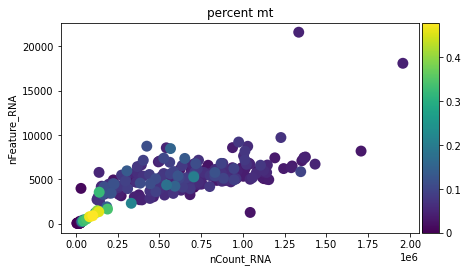

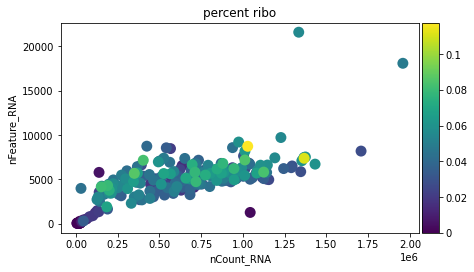

In [27]:
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_mt'
)
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_ribo'
)

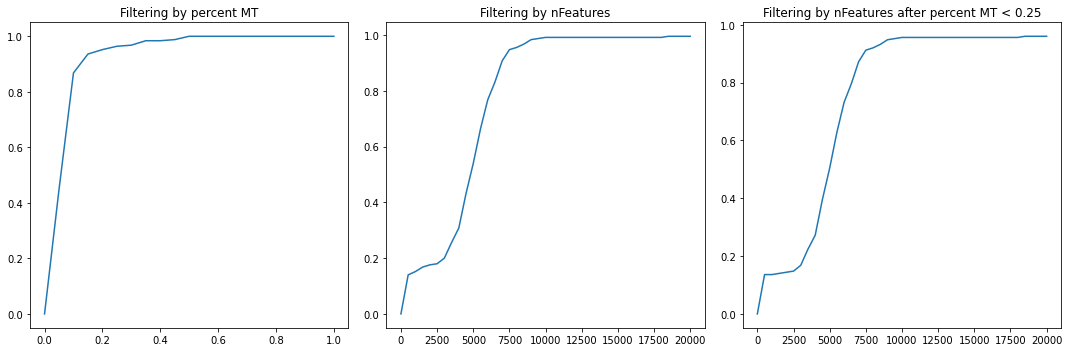

In [28]:
# Filtering cells
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
x1 = np.linspace(0, 1, 21)
data1 = [(adata.obs.percent_mt < i).sum()/len(adata.obs) for i in x1]
ax1.plot(x1, data1)
ax1.set_title('Filtering by percent MT')

x2 = np.linspace(0, 20000, 41)
data2 = [(adata.obs.nFeature_RNA < i).sum()/len(adata.obs) for i in x2]
ax2.plot(x2, data2)
ax2.set_title('Filtering by nFeatures')

data3 = [(adata[adata.obs.percent_mt < 0.25].obs.nFeature_RNA < i).sum()/len(adata.obs) for i in x2]
ax3.plot(x2, data3)
ax3.set_title('Filtering by nFeatures after percent MT < 0.25')

fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()

In [29]:
adata = adata[
    (adata.obs.nFeature_RNA > 2000) & 
    (adata.obs.nFeature_RNA < 15000) &
    (adata.obs.nCount_RNA < 1500000) &
    (adata.obs.percent_mt < 0.3), :].copy()
adata

AnnData object with n_obs × n_vars = 202 × 54456
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length', 'gencode_id'
    layers: 'counts', 'tpm'

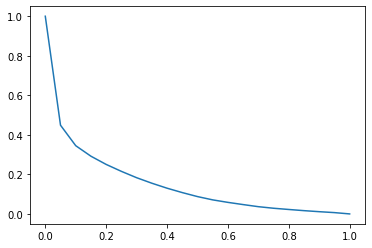

In [30]:
# Filtering genes
sc.pp.filter_genes(adata, min_counts = 5)

fig, ax = plt.subplots()
x = np.linspace(0, 1, 21)
expressed = np.array((adata.X > 0).sum(axis = 0)).flatten()/len(adata.obs)
data = [(expressed > i).sum()/len(expressed) for i in x]
ax.plot(x, data)

In [31]:
adata = adata[
    :, 
    ~adata.var.index.str.match('^Rp[sl]') & 
    ~adata.var.index.str.startswith('mt') & 
    (np.array((adata.X > 0).sum(axis = 0)).flatten() > 2)
].copy()
adata

AnnData object with n_obs × n_vars = 202 × 27051
    obs: 'sample_description', 'sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'percent_ribo'
    var: 'Length', 'gencode_id', 'n_counts'
    layers: 'counts', 'tpm'

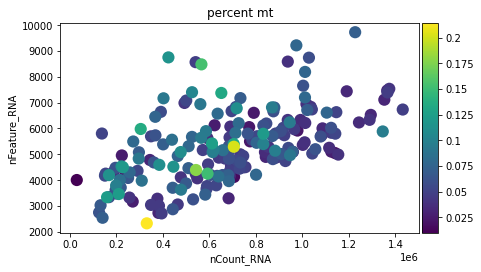

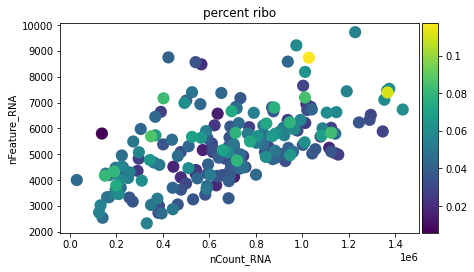

In [32]:
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_mt'
)
ax = sc.pl.scatter(
    adata, 
    'nCount_RNA', 
    'nFeature_RNA',
    show = False,
    color = 'percent_ribo'
)

In [33]:
adata.write_h5ad(
    '../processed/scRNAseq_salmon.filtered.h5ad'
)

In [34]:
adata = sc.read_h5ad(
    '../processed/scRNAseq_salmon.filtered.h5ad'
)
adata.X = adata.layers['tpm'].copy()
#basically seurat preprocessing
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [35]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1500,
    layer = 'counts',
    flavor = 'seurat_v3'
)
sc.pp.pca(
    adata, 
    n_comps = 40, 
    svd_solver = 'arpack',
    use_highly_variable = True,
)
sc.pp.neighbors(
    adata,
    n_neighbors = 5,
    knn = True
)
sc.tl.umap(adata)

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


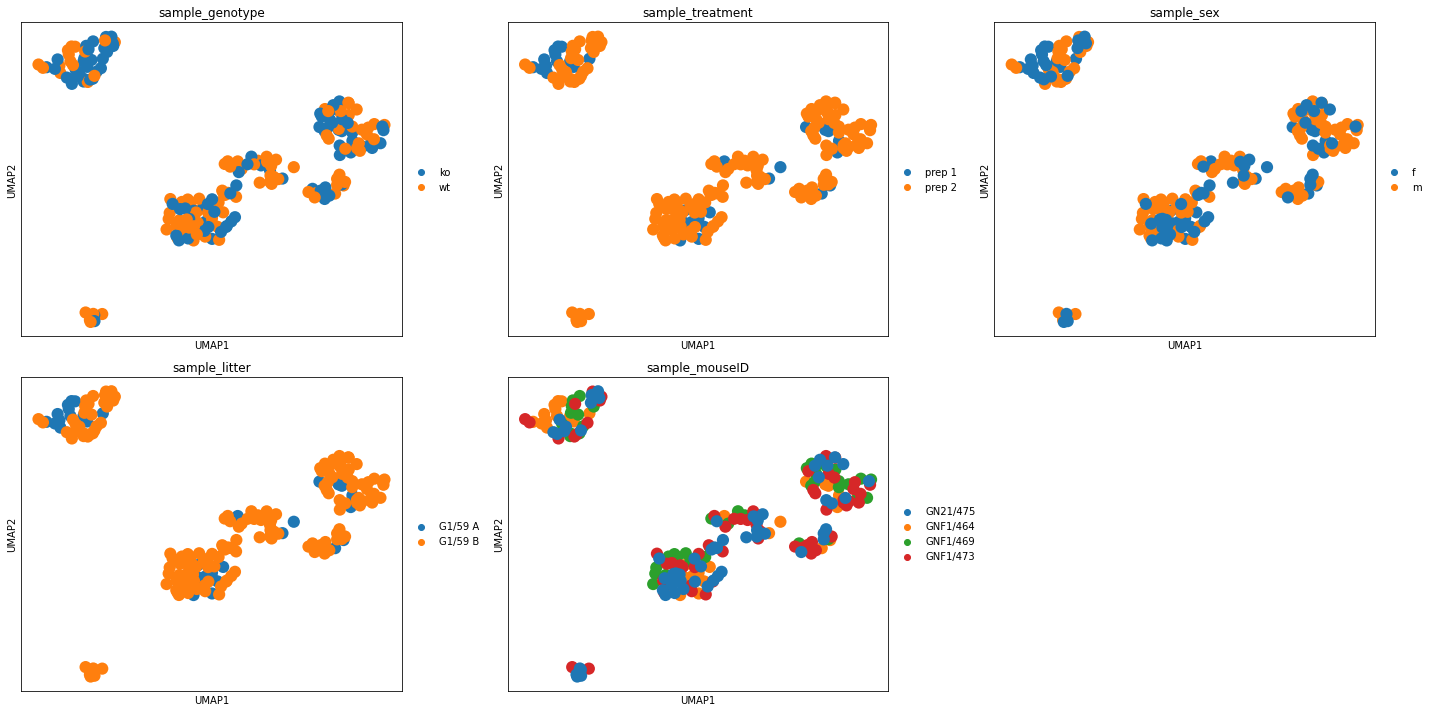

In [36]:
fig, axs = plt.subplots(2, 3)
keys = ['sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID']
for key, ax in zip(keys, axs.reshape(6)):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax
    )

axs[-1, -1].remove()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

In [37]:
resolutions = [0.25, 0.5, 0.75, 1]
for resolution in resolutions:
    sc.tl.leiden(
        adata, 
        resolution = resolution,
        key_added=f'leiden_r{resolution}'
    )

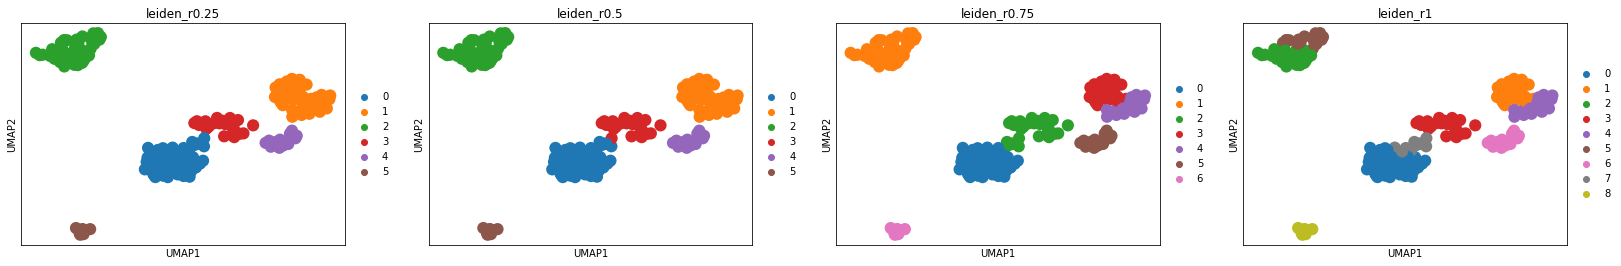

In [38]:
sc.pl.umap(
    adata,
    color = [f'leiden_r{resolution}' for resolution in resolutions]
)

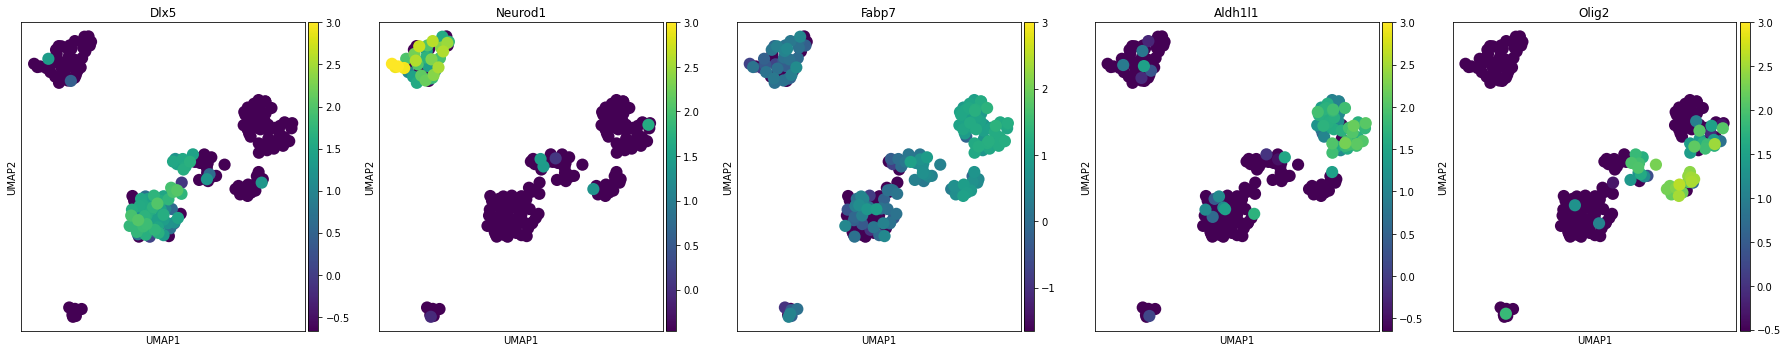

In [39]:
fig, axs = plt.subplots(1, 5)
keys = ['Dlx5', 'Neurod1', 'Fabp7', 'Aldh1l1', 'Olig2']
for key, ax in zip(keys, axs):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax,
        vmax = 3
    )

fig.set_figwidth(25)
fig.set_figheight(5)
fig.tight_layout()

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


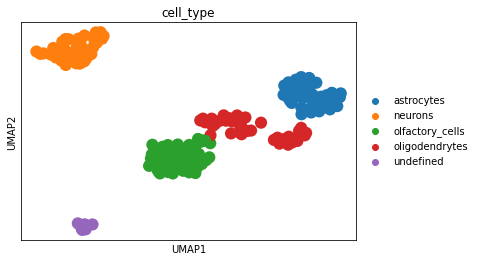

In [40]:
# Dlx5 is a marker of olfactory cells, Neurod1 is a marker of neurons, Fabp7 and Aldh1l1 are markers of astrocytes and Olig2 is a marker of oligodendrytes
cell_assignment = {
    '0': 'olfactory_cells',
    '1': 'astrocytes',
    '2': 'neurons',
    '3': 'oligodendrytes',
    '4': 'oligodendrytes',
    '5': 'undefined'
}
adata.obs['cell_type'] = adata.obs['leiden_r0.5'].apply(
    lambda x: cell_assignment[x]
)
sc.pl.umap(
    adata,
    color = 'cell_type'
)

In [41]:
adata.write(
    '../processed/scRNAseq_salmon.clustered.h5ad'
)

## Overlap between annotations

In [42]:
# preparing data for plotting with seaborn
import pandas as pd
columns = [
    'sample_treatment', 
    'sample_sex', 
    'sample_litter', 
    'sample_mouseID', 
    'cell_type',
    'quantification'
]
annotation = {
    0: 'olfactory_cells',
    1: 'oligodendrytes',
    2: 'astrocytes',
    3: 'neurons'
}
cells_novarino = sc.read_h5ad('../processed/novarino_scRNA.h5ad').obs.copy()
cells_novarino.index = [x.split('_')[1] for x in cells_novarino.index]
cells_novarino['cell_type'] = cells_novarino.seurat_clusters.apply(lambda x: annotation[x])
cells_novarino['quantification'] = 'novarino'

# reading featurecounts and salmon quant clustering
cells_salmon = sc.read_h5ad('../processed/scRNAseq_salmon.clustered.h5ad').obs.copy()
cells_salmon['quantification'] = 'salmon'

cells_featurecounts = sc.read_h5ad('../processed/scRNAseq_featureCounts.clustered.h5ad').obs.copy()
cells_featurecounts['quantification'] = 'featureCounts'

df = pd.concat(
    [tmp.loc[:, columns].copy() for tmp in [cells_novarino, cells_salmon, cells_featurecounts]]
)
df.reset_index(
    inplace = True
)
df

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


,index,sample_treatment,sample_sex,sample_litter,sample_mouseID,cell_type,quantification
0,162322,prep 1,f,G1/59 A,GNF1/464,olfactory_cells,novarino
1,162323,prep 1,f,G1/59 A,GNF1/464,oligodendrytes,novarino
2,162324,prep 1,f,G1/59 A,GNF1/464,olfactory_cells,novarino
3,162325,prep 1,f,G1/59 A,GNF1/464,neurons,novarino
4,162326,prep 1,f,G1/59 A,GNF1/464,neurons,novarino
...,...,...,...,...,...,...,...
602,162561,prep 2,f,G1/59 B,GN21/475,neurons,featureCounts
603,162562,prep 2,f,G1/59 B,GN21/475,oligodendrytes,featureCounts
604,162563,prep 2,f,G1/59 B,GN21/475,neurons,featureCounts
605,162564,prep 2,f,G1/59 B,GN21/475,oligodendrytes,featureCounts


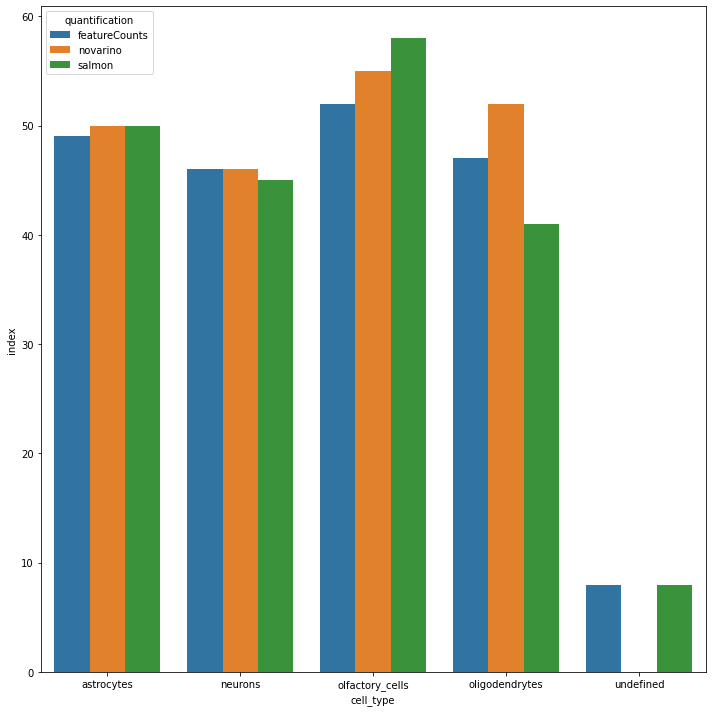

In [43]:
import seaborn as sns
fig, ax = plt.subplots()
sns.barplot(
    x = 'cell_type',
    y = 'index',
    hue = 'quantification',
    data = df.groupby(['quantification', 'cell_type']).agg('count').reset_index()
)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.tight_layout()

/users/daniel.malzl/.conda/envs/nova/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


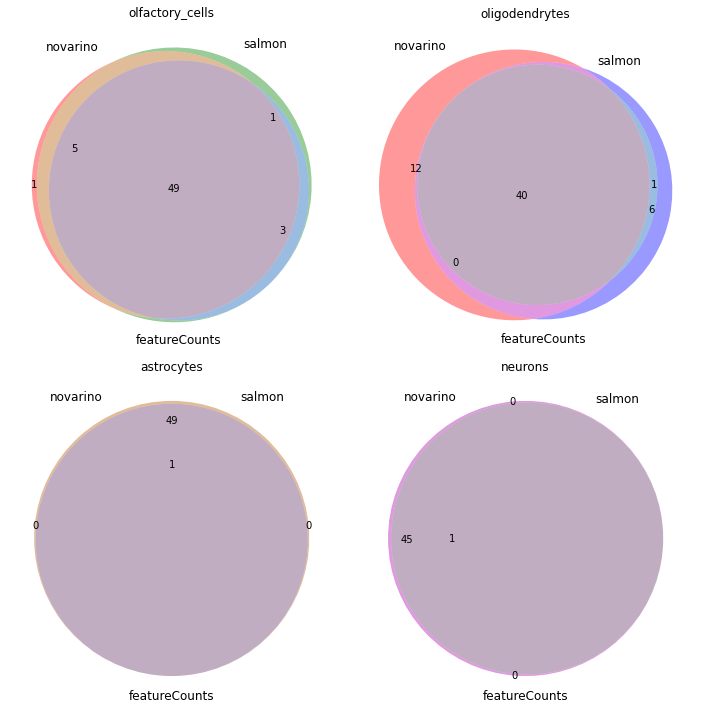

In [44]:
from matplotlib_venn import venn3
fig, axs = plt.subplots(2, 2)
quantifications = [
    'novarino',
    'salmon',
    'featureCounts'
]
for cell_type, ax in zip(
    annotation.values(),
    axs.reshape(4)
):
    venn3(
        [set(df.loc[(df.cell_type == cell_type) & (df.quantification == quant), 'index']) for quant in quantifications],
        quantifications,
        ax = ax
    )
    ax.set_title(cell_type)

fig.set_figwidth(10)
fig.set_figheight(10)
fig.tight_layout()

All three quantification methods perform similar when using the Gencode annotation and reference for alignment with nf-core rnaseq pipeline

## SCVI testrun
Might not work so well for small samples like this. Compared to traditional methods

In [36]:
import scvi
scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
   # continuous_covariate_keys = ['percent_mt', 'percent_ribo']
)

Global seed set to 0


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 203 cells, 26722 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [37]:
model = scvi.model.SCVI(adata)

In [38]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Set SLURM handle signals.


Epoch 400/400: 100%|██████████| 400/400 [07:10<00:00,  1.08s/it, loss=2.87e+04, v_num=1]


In [39]:
adata.obsm['X_scvi'] = model.get_latent_representation()

In [40]:
adata.layers["scvi"] = model.get_normalized_expression(
    library_size=10e4
)

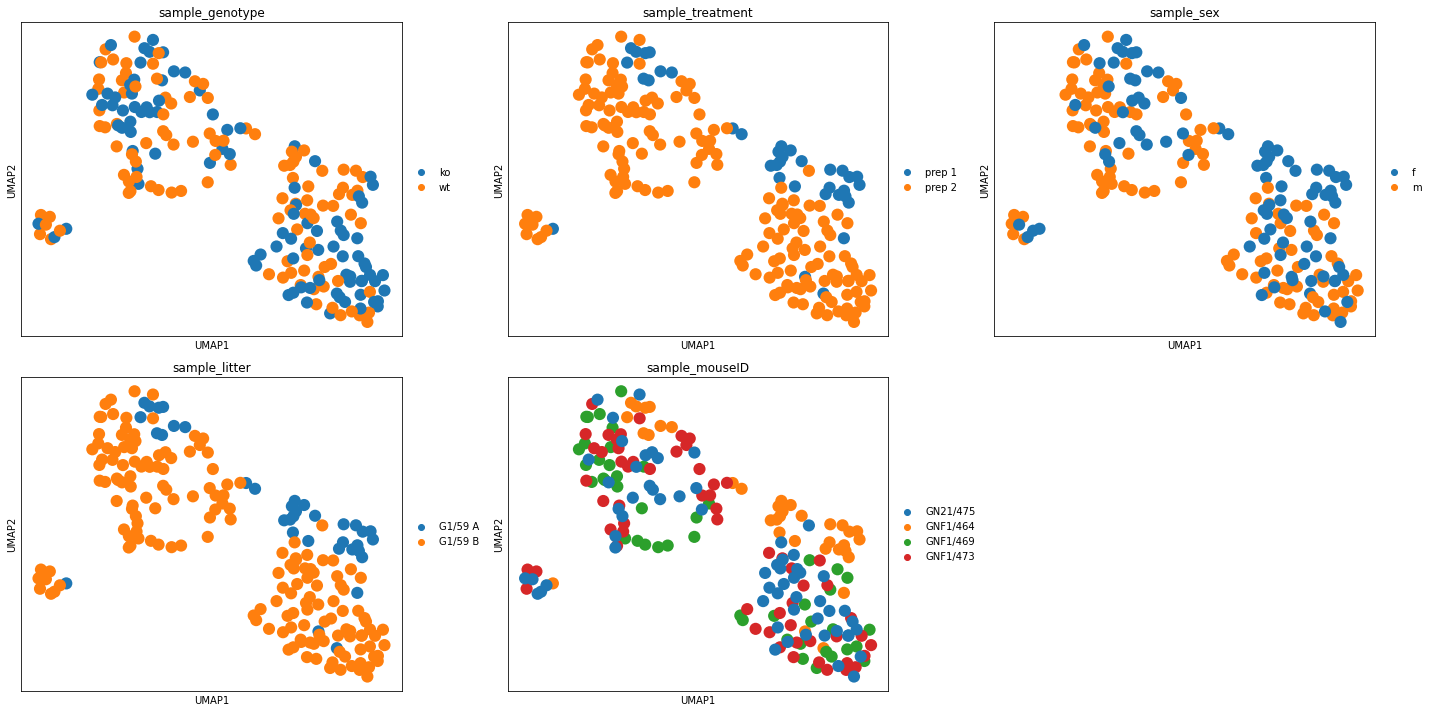

In [41]:
sc.pp.neighbors(
    adata, 
    use_rep="X_scvi",
    n_neighbors = 5,
    knn = True
)
sc.tl.umap(adata)
fig, axs = plt.subplots(2, 3)
keys = ['sample_genotype', 'sample_treatment', 'sample_sex', 'sample_litter', 'sample_mouseID']
for key, ax in zip(keys, axs.reshape(6)):
    sc.pl.umap(
        adata,
        color = key,
        show = False,
        ax = ax
    )

axs[-1, -1].remove()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

<AxesSubplot:title={'center':'Neurod1'}, xlabel='UMAP1', ylabel='UMAP2'>

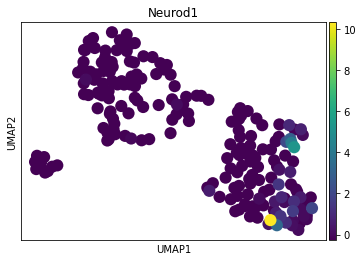

In [43]:
sc.pl.umap(
    adata,
    color = 'Neurod1',
    show = False,
)